## Combine label JSON files into a single JSONL

This notebook reads individual JSON label files in `data/labels/` and writes them to `data/labels/labels.jsonl` (one JSON object per line). It skips files that fail to parse and reports a count.

Run the first code cell to create the `labels.jsonl` file, then run the preview cell to inspect the first few lines.

In [ ]:
from pathlib import Path
import json
import pickle
from joblib import dump


project_root = Path(Path.cwd()).resolve().parent
labels_dir = project_root / 'data' / 'potential_labels'
jsonl_path = project_root / 'data' / 'ingredients.jsonl'

# Ensure the labels directory exists
if not labels_dir.exists():
    print(f"Directory {labels_dir} does not exist. Please create it and add JSON files.")
    exit(1)

# Collect JSON files (sorted for determinism)
files = sorted([p for p in labels_dir.iterdir() if p.is_file() and p.suffix == '.json'])

written = 0
with jsonl_path.open('w', encoding='utf-8') as out_f:
    for fp in files:
        try:
            text = fp.read_text(encoding='utf-8')
            obj = json.loads(text)
        except Exception as e:
            # Log and continue on parse/read errors
            print(f'Skipping {fp.name}: {e}')
            continue
        # add source filename so downstream steps know which file produced this record
        if isinstance(obj, dict) and obj.get("title") and obj.get("ingredients"):
            title_instructions_file = {
                "title" : obj["title"],
                "ingredients": obj["ingredients"],
                "source_file": fp.name
            }
            out_f.write(json.dumps(title_instructions_file, ensure_ascii=False) + '\n')
            written += 1

print(f'Wrote {written} records to {jsonl_path}')

Wrote 19945 records to /Users/kriserickson/Projects/python/recipe-parser/data/labels.jsonl


In [ ]:
# --- Build TF‑IDF matrix X from a JSONL of ingredients, titles and filename ---

import re
from pathlib import Path
from typing import Dict, Any, List
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd  

def _as_list(x) -> List[str]:
    "Normalize a field into a list of strings."
    if x is None:
        return []
    if isinstance(x, str):
        return [x]
    if isinstance(x, (list, tuple)):
        return [str(t) for t in x if t is not None]
    # Unknown type -> string
    return [str(x)]


MEASURE_WORDS = set("""
t tsp tablespoon tablespoons tbps tbsp tsps teaspoon teaspoons cup cups
oz ounce ounces lb lbs pound pounds g gram grams kg kilogram kilograms ml
l liter liters litre litres package packages can cans jar jars pinch pinches
small medium large
""".split())

def _clean_tokens(text: str) -> str:
    """
    Light cleaning: lowercase, remove punctuation, collapse spaces.
    we’ll drop obvious measure tokens and any standalone numbers.
    """
    text = text.lower()
    # keep letters, numbers, and spaces
    text = re.sub(r"[^a-z0-9\s\-']", " ", text)
    # split and drop measure words and only numbers
    toks = [t for t in text.split() if t not in MEASURE_WORDS and not re.match(r"^\d+$", t)]
    # collapse multiple spaces
    return re.sub(r'\s+', ' ', ' '.join(toks)).strip()


def load_recipe_rows(path: str | Path) -> List[Dict[str, Any]]:
    # read_json with lines=True expects one JSON object per line
    df = pd.read_json(path, lines=True, orient='records')
    # convert dataframe rows to list of dicts; drop NaNs by converting to native python types
    records = df.where(pd.notnull(df), None).to_dict(orient='records')
    return [r for r in records if isinstance(r, dict)]
 

def build_ingredients_text_from_record(rec: Dict[str, Any]) -> str:
    """
    Combine ingredients into a single text blob.
    """
    ingredients = _as_list(rec.get("ingredients"))
    combined = " ".join(ingredients)
    return _clean_tokens(combined)


# ---- Load, normalize, and vectorize ----
rows = load_recipe_rows(jsonl_path)

# Keep a simple index, title map, and source filename list for later use (search/results)
titles: List[str] = []
texts: List[str] = []
filenames: List[str] = []        
for rec in rows:
    text = build_ingredients_text_from_record(rec)
    if not text:
        continue
    texts.append(text)
    titles.append(str(rec.get("title")))
    # capture original source filename injected when creating the JSONL
    filenames.append(str(rec.get("source_file")))

print(f"Loaded {len(rows):,} JSON objects; using {len(texts):,} non-empty recipe texts.")

# Vectorize with TF‑IDF.
# You can tune min_df/max_df and ngram_range. Start simple; adjust if vocabulary is too noisy.
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.8,     # drop terms in >80% of docs (very common)
    min_df=2,       # keep terms appearing in at least 2 docs
    ngram_range=(1,2)  # unigrams + bigrams helps with phrases like "butternut squash"
)

X = vectorizer.fit_transform(texts)

print("X shape:", X.shape)  # (n_recipes_kept, vocab_size)

Loaded 19,945 JSON objects; using 19,841 non-empty recipe texts.
X shape: (19841, 58431)


Matplotlib is building the font cache; this may take a moment.


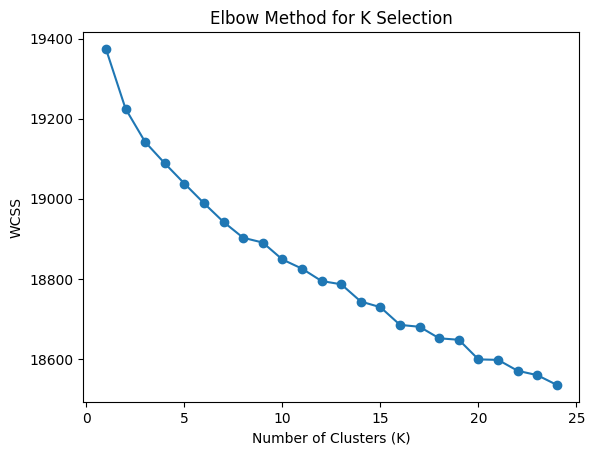

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=500)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_) 

plt.plot(range(1, 25), wcss, marker='o') 
plt.xlabel("Number of Clusters (K)") 
plt.ylabel("WCSS") 
plt.title("Elbow Method for K Selection") 
plt.show()



Best K by silhouette: 2


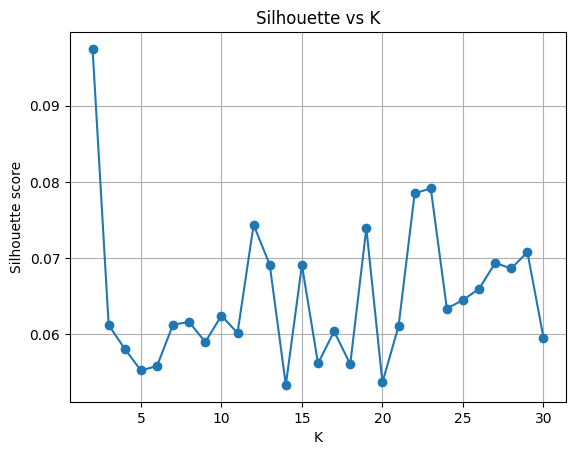

In [12]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# reduce to ~50 dims for clustering/metrics
n_comp = min(50, X.shape[1]-1)
X_svd = TruncatedSVD(n_components=n_comp, random_state=42).fit_transform(X)

ks = list(range(2, 31))
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=500)
    labels = km.fit_predict(X_svd)
    sil = silhouette_score(X_svd, labels)
    sil_scores.append(sil)

best_k = ks[int(np.argmax(sil_scores))]
print("Best K by silhouette:", best_k)
# plot silhouette scores

plt.plot(ks, sil_scores, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs K")
plt.grid(True)
plt.show()

In [13]:

k = 10  # From the silhouette method and the elbow method k 8-12 would be the sweet spot.  Lets go right in the middle.
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X) 

print(f"Clustered into {k} groups.")

Clustered into 10 groups.


In [14]:
# Save artifacts
with open(project_root / "models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open(project_root / "models/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open(project_root / "models/recipe_titles.pkl", "wb") as f:
    pickle.dump(titles, f)

# save filenames in the same order as titles/X
with open(project_root / "models/recipe_filenames.pkl", "wb") as f:   # <-- new
    pickle.dump(filenames, f)

with open(project_root / "models/cluster_labels.pkl", "wb") as f:
    pickle.dump(labels, f)

# Optionally: save the X matrix (can be large)
dump(X, project_root / "models/tfidf_matrix.joblib")   # joblib handles sparse matrices efficiently

['C:\\Projects\\Python\\RecipeParser\\models\\tfidf_matrix.joblib']